In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import RandomOverSampler
import math
# Load data in a dataframe:
df = pd.read_csv("winequality-red.csv")
y = df['quality']
df.drop('quality', axis='columns', inplace=True)


#df.drop('pH', axis='columns', inplace=True)

# Linear Regression


In [2]:
dfl=pd.read_csv("winequality-red.csv")
dfl.drop('quality',axis='columns', inplace=True) 
data = dfl.to_numpy()
vif = [variance_inflation_factor(data, i) for i in range(data.shape[1])]
for i in range(11):
    print("VIF of " + dfl.columns[i] + ": " + str(vif[i]))
dfl['constant'] = [1]*1599 #for linear reg
res = sm.OLS(y,dfl).fit()
print(res.summary())


VIF of fixed acidity: 74.45226538735389
VIF of volatile acidity: 17.060026123932275
VIF of citric acid: 9.183495167192477
VIF of residual sugar: 4.662992174051856
VIF of chlorides: 6.5548772185559905
VIF of free sulfur dioxide: 6.442682022072097
VIF of total sulfur dioxide: 6.519698942374763
VIF of density: 1479.2872086341736
VIF of pH: 1070.9676853792205
VIF of sulphates: 21.5906209233164
VIF of alcohol: 124.39486649768077
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sat, 27 Nov 2021   Prob (F-statistic):          1.79e-145
Time:                        10:33:47   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:      

> We can observe from VIF and P-values for coefficients fo the regression that some variables ( density, citric acid, fixed acidity, residual sugar, free sulfur dioxide) are redundant. From p-values we can not reject ${H}_{0}$ , thus their coefficient is 0 and we can remove them from the regression analysis. 

In [3]:
#Remove variables according to P-values
dfl.drop('free sulfur dioxide', axis='columns', inplace=True)
dfl.drop('density', axis='columns', inplace=True)
dfl.drop('fixed acidity', axis='columns', inplace=True)
dfl.drop('citric acid', axis='columns', inplace=True)
dfl.drop('residual sugar', axis='columns', inplace=True)

data = dfl.to_numpy()
vif = [variance_inflation_factor(data, i) for i in range(data.shape[1])]
for i in range(5):
    print("VIF of " + dfl.columns[i] + ": " + str(vif[i]))

VIF of volatile acidity: 1.227966801646607
VIF of chlorides: 1.3329767249777098
VIF of total sulfur dioxide: 1.053829759009383
VIF of pH: 1.2187072163627097
VIF of sulphates: 1.3212374333930237


>As we see from the new VIF values above, we can keep all the remaining variables in the regression, since their VIF is low. Thus our choice to remove some variables was effecetive.

### Train-Test Split for Linear Regression

In [4]:
Xtrain,Xtest,ytrain,ytest = train_test_split(dfl,y,random_state =0)

In [5]:
from sklearn.metrics import r2_score

res = sm.OLS(ytrain,Xtrain).fit()
linpred=res.predict(Xtest)
print("Testing R^2:",r2_score(ytest, linpred))
print(res.summary())

Testing R^2: 0.3400315594249539
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     112.1
Date:                Sat, 27 Nov 2021   Prob (F-statistic):          3.33e-112
Time:                        10:33:48   Log-Likelihood:                -1188.5
No. Observations:                1199   AIC:                             2391.
Df Residuals:                    1192   BIC:                             2427.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------




#### *Result Anlysis*

<p> From the above summray of the linear regression we can see that the p-value for each coefficinet is small, thus for each of them we can reject the null hypothesis and say that coefficients are signifficantly different from 0. </p>

<p> We were using 7 variables for the regression, the magnitude of respective coefficients as well as the 95% confidence interval for them is given below. </p>

|Variable| Coefficient| 95% confidence interval |
|:-| :- | :-: |
|Volatile Acidity|  -1.1704 | \[-1.394 ,-0.947 \]|
|Chlorides|  -1.9238 | \[-2.803 ,-1.044 \]|
|Total Sulfur Dioxide|  -0.0023   | \[-0.003 ,-0.001 \]|
|pH| -0.4174 | \[-0.684 , -0.151 \]|
|Sulphates| 0.8148 | \[0.575 , 1.055 \]|
|Alcohol| 0.2832 | \[0.245 ,  0.321 \]|


<p> The accuracy of the model was decent but not impressive, the  values are in the table below. </p>

|Variable|$R^2$ Accuracy|
|:-|:- |
|Testing Accuracy| 0.34|
|Training Accuracy| 0.36|

<p> Even though linear regression can be validely applied to this dataset, intuitivelly it is easy to notice that the given task is more of a classification task rather than a regression problem. Morover the response variable only presents quality as an integer, but our regression returns float values. Thus the relativetly low accuracy of $R^2$ = 0.34 was expected. Classification approach to the problem might work better </p>

# Classification


### Train-Test Split for Classification

Here we will be performing classification analysis for the dataset. We will make a new responce variable which will classify everthing with >7 quality index as High(1) quality wine, and everything else as low(0) quality. This leaves us with a binary Classification problem.

In [6]:
# Add standardization? 
yc = np.zeros(len(y))
for i in range(len(y)):
    yc[i] = y[i]>=7.0
Xtrain,Xtest,ytrain,ytest = train_test_split(df,yc,random_state =0)


## Random Forest

In [7]:
tree_clf = RandomForestClassifier(n_estimators=100,random_state=0)
tree_clf.fit(Xtrain,ytrain)
ypred=tree_clf.predict(Xtest)
print(tree_clf.score(Xtest, ytest))
print(metrics.classification_report(ytest,ypred))

0.93
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       355
         1.0       0.72      0.62      0.67        45

    accuracy                           0.93       400
   macro avg       0.84      0.80      0.81       400
weighted avg       0.93      0.93      0.93       400



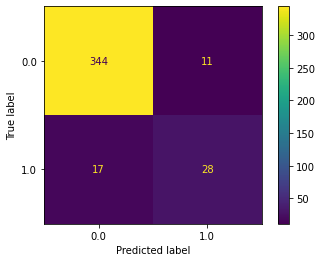

In [8]:
from sklearn import svm
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred)    

In [9]:
importances = tree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_clf.estimators_], axis=0)
for i in range(len(std)):
    print("Feature "+str((i+1))+" importance is:"+str(round(importances[i],2)) +" 95% confidence interval: ["+str(round(importances[i]-2*std[i],2))+","+str(round(importances[i]+2*std[i],2))+"]"+" ("+df.columns[i]+")")

Feature 1 importance is:0.07 95% confidence interval: [0.01,0.14] (fixed acidity)
Feature 2 importance is:0.12 95% confidence interval: [0.02,0.22] (volatile acidity)
Feature 3 importance is:0.09 95% confidence interval: [0.01,0.16] (citric acid)
Feature 4 importance is:0.07 95% confidence interval: [0.02,0.12] (residual sugar)
Feature 5 importance is:0.07 95% confidence interval: [0.01,0.13] (chlorides)
Feature 6 importance is:0.06 95% confidence interval: [0.01,0.1] (free sulfur dioxide)
Feature 7 importance is:0.08 95% confidence interval: [0.03,0.14] (total sulfur dioxide)
Feature 8 importance is:0.09 95% confidence interval: [0.01,0.17] (density)
Feature 9 importance is:0.06 95% confidence interval: [0.0,0.11] (pH)
Feature 10 importance is:0.12 95% confidence interval: [0.03,0.22] (sulphates)
Feature 11 importance is:0.17 95% confidence interval: [0.06,0.27] (alcohol)


#### Random Forest on filtered data

0.9125
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       355
         1.0       0.62      0.56      0.59        45

    accuracy                           0.91       400
   macro avg       0.78      0.76      0.77       400
weighted avg       0.91      0.91      0.91       400

Feature 1 importance is:0.2 95% confidence interval: [0.1,0.29] (volatile acidity)
Feature 2 importance is:0.13 95% confidence interval: [0.07,0.2] (chlorides)
Feature 3 importance is:0.14 95% confidence interval: [0.07,0.21] (total sulfur dioxide)
Feature 4 importance is:0.12 95% confidence interval: [0.05,0.19] (pH)
Feature 5 importance is:0.18 95% confidence interval: [0.11,0.26] (sulphates)
Feature 6 importance is:0.23 95% confidence interval: [0.14,0.32] (alcohol)


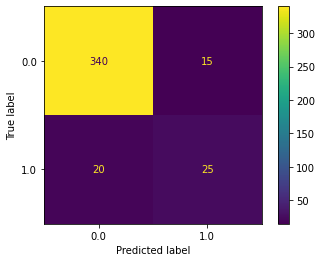

In [10]:
df.drop('free sulfur dioxide', axis='columns', inplace=True)
df.drop('density', axis='columns', inplace=True)
df.drop('fixed acidity', axis='columns', inplace=True)
df.drop('citric acid', axis='columns', inplace=True)
df.drop('residual sugar', axis='columns', inplace=True)

Xtrain,Xtest,ytrain,ytest = train_test_split(df,yc,random_state =0)

tree_clf_1 = RandomForestClassifier(n_estimators=100,random_state=0)
tree_clf_1.fit(Xtrain,ytrain)
ypred=tree_clf_1.predict(Xtest)
print(tree_clf_1.score(Xtest, ytest))
print(metrics.classification_report(ytest,ypred))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, ypred)  

importances_1 = tree_clf_1.feature_importances_
std_1 = np.std([tree.feature_importances_ for tree in tree_clf_1.estimators_], axis=0)
for i in range(len(std_1)):
    print("Feature "+str((i+1))+" importance is:"+str(round(importances_1[i],2)) +" 95% confidence interval: ["+str(round(importances_1[i]-2*std_1[i],2))+","+str(round(importances_1[i]+2*std_1[i],2))+"]"+" ("+df.columns[i]+")")

## Nonbinary Classification

### Data Train-test Split and Standardisation
We begin by resplitting and standardising our data.

Text(0.5, 1.0, 'Histogram of the Training Set')

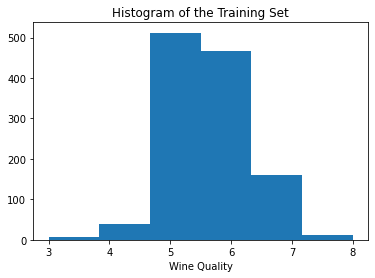

In [11]:
X_train,X_test,ytrain,ytest = train_test_split(df,y,random_state =0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plt.hist(ytrain, bins=6)
plt.xlabel('Wine Quality')
plt.title('Histogram of the Training Set')

The graph above shows that the data is very imbalanced, hence this needs to be taken into account by our models.

After trying to use the *class_weight = 'balanced'* parameter for our models, the accuracy of our models diminished. We realized that working with a completely balanced dataset does not reflect the reality of our data, so we decided to use oversapling since the dataset is small, so undersampling would not work quite well. 

When using completely balanced oversampling of all classes, the accuracy of our models decreased and more points of classes 5 and 6 were mislabeled as other classes, but there was siginificant improvemnt in the correct identification of data from class 7.

To fix that, we tried ovarsampling in a bit more catious manner, by doubling classes 3, 4, 7, and 8, which have significantly less data than classes 5 and 6. The results were the same for the Logistic Regressor and the SVM, but the Random Forest Classifier performed better with this oversampling.<br>

Text(0.5, 1.0, 'Histogram of the Oversampled Training Set')

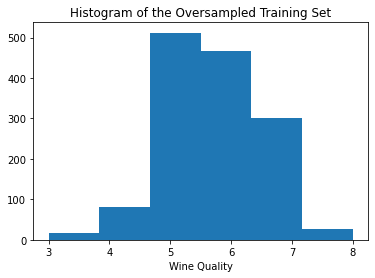

In [12]:
# Oversampling of the training data
ros = RandomOverSampler(sampling_strategy={3:16, 4:80, 7:300, 8:26})
X_train_ros, ytrain_ros = ros.fit_resample(X_train, ytrain)

plt.hist(ytrain_ros, bins=6)
plt.xlabel('Wine Quality')
plt.title('Histogram of the Oversampled Training Set')

### Logistic Regression Classifier

Accuracy is not affected by scaling, but the number of iterations blew up.

Accuracy when max_iter=1000, class_weight='balanced': 0.43

Normal accuracy with max_iter = 1000: 0.635. Different solvers did not change the accuracy for this one. 

0.63


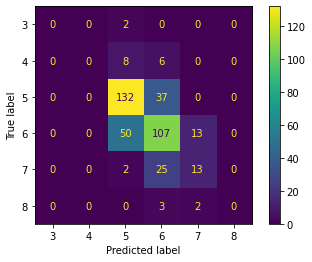

In [13]:
# Logistic Regression without oversampling

classifier = LogisticRegression(max_iter=1000, multi_class='multinomial')
classifier.fit(X_train, ytrain)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  


0.585


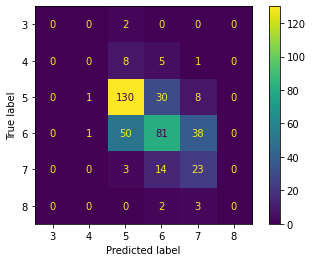

In [14]:
# Logistic regression with oversampling
classifier.fit(X_train_ros, ytrain_ros)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

### Random Forest Classifier

Default accuracy is 0.7

0.71


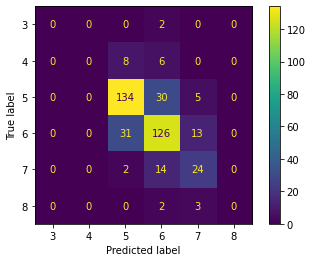

In [15]:
#Random forest classifier without oversampling
classifier = RandomForestClassifier(
    n_estimators = 1000,
    random_state = 0,
    oob_score = True
)
classifier.fit(X_train, ytrain)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.6975


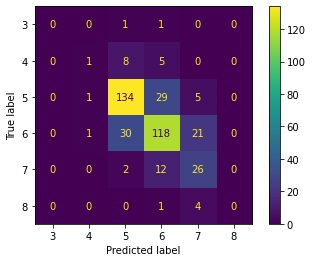

In [16]:
# Random forest classifier with oversampling
classifier.fit(X_train_ros, ytrain_ros)
predicted = classifier.predict(X_test)
print(classifier.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.635


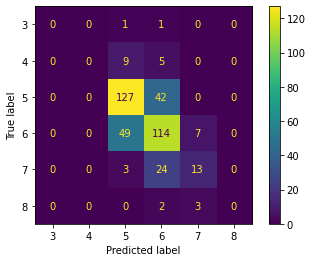

In [18]:
# SVM without oversampling
clf = svm.SVC(random_state=0)
clf.fit(X_train, ytrain)
predicted = clf.predict(X_test)
print(clf.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  

0.5775


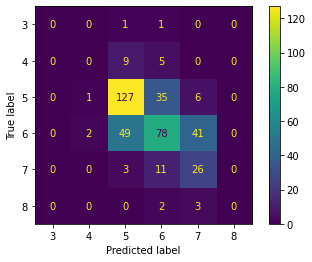

In [19]:
# SVM with oversampling
clf.fit(X_train_ros, ytrain_ros)
predicted = clf.predict(X_test)
print(clf.score(X_test, ytest))
disp = metrics.ConfusionMatrixDisplay.from_predictions(ytest, predicted)  